In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
path="/content/drive/MyDrive/skin_data"
train_images_path=os.path.join(path,"train_data")
train_mask_path=os.path.join(path,"train_label")

In [4]:
import os
import cv2
import numpy as np
from random import shuffle
def read_data(images_path, masks_path):
    images = []
    masks = []
    i = 0

    for subdir, dirs, files in os.walk(images_path):
        for file in files:
            mask_file = os.path.splitext(file)[0]
            mask_file=mask_file+'.png'

            image = cv2.imread(os.path.join(images_path, file))
            mask = cv2.imread(os.path.join(masks_path, mask_file))

            # Resize the image and mask
            image = cv2.resize(image, (224,224))
            mask = cv2.resize(mask, (224,224))

            # Convert the mask to grayscale
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

            # Expand the dimensions of the mask
            mask = np.expand_dims(mask, axis=-1)

            # Apply image augmentations
            images.append(image/255.0)
            masks.append(mask/255.0)
            if i%50==0:
              print(i)
            i=i+1

    # Shuffle the images and masks
    combined = list(zip(images, masks))
    shuffle(combined)
    images, masks = zip(*combined)
    images = np.array(images)
    masks = np.array(masks)

    return images, masks


In [5]:
train_images,train_masks=read_data(train_images_path,train_mask_path)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850


In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% train, 20% validate)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

print("Train Images Shape:", train_images.shape)
print("Train Masks Shape:", train_masks.shape)
print("Validation Images Shape:", val_images.shape)
print("Validation Masks Shape:", val_masks.shape)


Train Images Shape: (720, 224, 224, 3)
Train Masks Shape: (720, 224, 224, 1)
Validation Images Shape: (180, 224, 224, 3)
Validation Masks Shape: (180, 224, 224, 1)


In [7]:
IMAGE_SIZE = 224
NUM_CLASSES = 1

## Building the DeepLabV3+ model

DeepLabv3+ extends DeepLabv3 by adding an encoder-decoder structure. The encoder module
processes multiscale contextual information by applying dilated convolution at multiple
scales, while the decoder module refines the segmentation results along object boundaries.

![](https://github.com/lattice-ai/DeepLabV3-Plus/raw/master/assets/deeplabv3_plus_diagram.png)

**Dilated convolution:** With dilated convolution, as we go deeper in the network, we can keep the
stride constant but with larger field-of-view without increasing the number of parameters
or the amount of computation. Besides, it enables larger output feature maps, which is
useful for semantic segmentation.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the
sampling rate becomes larger, the number of valid filter weights (i.e., weights that
are applied to the valid feature region, instead of padded zeros) becomes smaller.

In [8]:

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


The encoder features are first bilinearly upsampled by a factor 4, and then
concatenated with the corresponding low-level features from the network backbone that
have the same spatial resolution. For this example, we
use a ResNet50 pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

In [9]:

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [10]:
import tensorflow as tf

# Define custom IoU metric function
def iou_score(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, dtype=tf.float32)
    y_pred = tf.cast(y_pred > 0.5, dtype=tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / union
    return iou

def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def f1_score(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    actual_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())

    f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    return f1


In [11]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=["accuracy",iou_score,dice_coefficient,f1_score],
)

history = model.fit(train_images,train_masks,batch_size=2,validation_data=(val_images,val_masks), epochs=10)


Epoch 1/10
360/360 [==============================] - 1538s 4s/step - loss: 1.0563 - accuracy: 0.8358 - iou_score: 0.5223 - dice_coefficient: -13.6145 - f1_score: 0.6680 - val_loss: 3.9483 - val_accuracy: 0.7429 - val_iou_score: 0.0000e+00 - val_dice_coefficient: 0.6253 - val_f1_score: 0.0000e+00
Epoch 2/10
360/360 [==============================] - 1525s 4s/step - loss: 0.4255 - accuracy: 0.8712 - iou_score: 0.6201 - dice_coefficient: 2.2536 - f1_score: 0.7478 - val_loss: 0.5318 - val_accuracy: 0.7429 - val_iou_score: 1.1402e-04 - val_dice_coefficient: 0.2558 - val_f1_score: 2.2688e-04
Epoch 3/10
360/360 [==============================] - 1474s 4s/step - loss: 0.4549 - accuracy: 0.8182 - iou_score: 0.3970 - dice_coefficient: -1.5842 - f1_score: 0.4911 - val_loss: 0.6143 - val_accuracy: 0.8405 - val_iou_score: 0.4841 - val_dice_coefficient: -0.4325 - val_f1_score: 0.6330
Epoch 4/10
360/360 [==============================] - 1476s 4s/step - loss: 0.4024 - accuracy: 0.8753 - iou_score: 0

6/6 [==============================] - 76s 12s/step


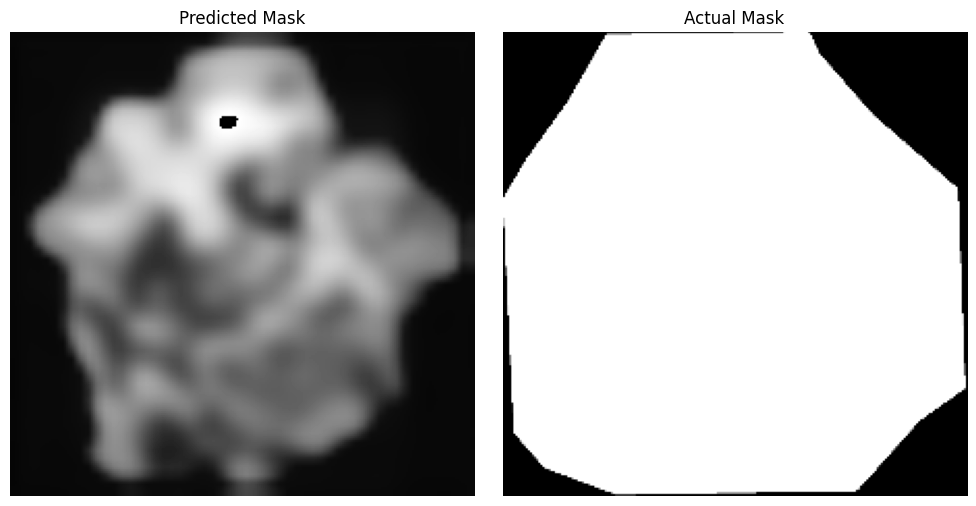

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Predict masks using the trained model
predicted_masks = model.predict(val_images)

# Display the predicted and actual masks
num_samples = len(val_images)

for i in range(num_samples):
    # Rescale the predicted and actual masks to the range [0, 1]
    predicted_mask = predicted_masks[i] * 255.0
    actual_mask = val_masks[i] * 255.0

    # Convert the masks to uint8 for visualization
    predicted_mask = predicted_mask.astype(np.uint8)
    actual_mask = actual_mask.astype(np.uint8)

    # Display the predicted and actual masks
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(predicted_mask, cmap='gray')
    axes[0].set_title('Predicted Mask')
    axes[0].axis('off')
    axes[1].imshow(actual_mask, cmap='gray')
    axes[1].set_title('Actual Mask')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    break


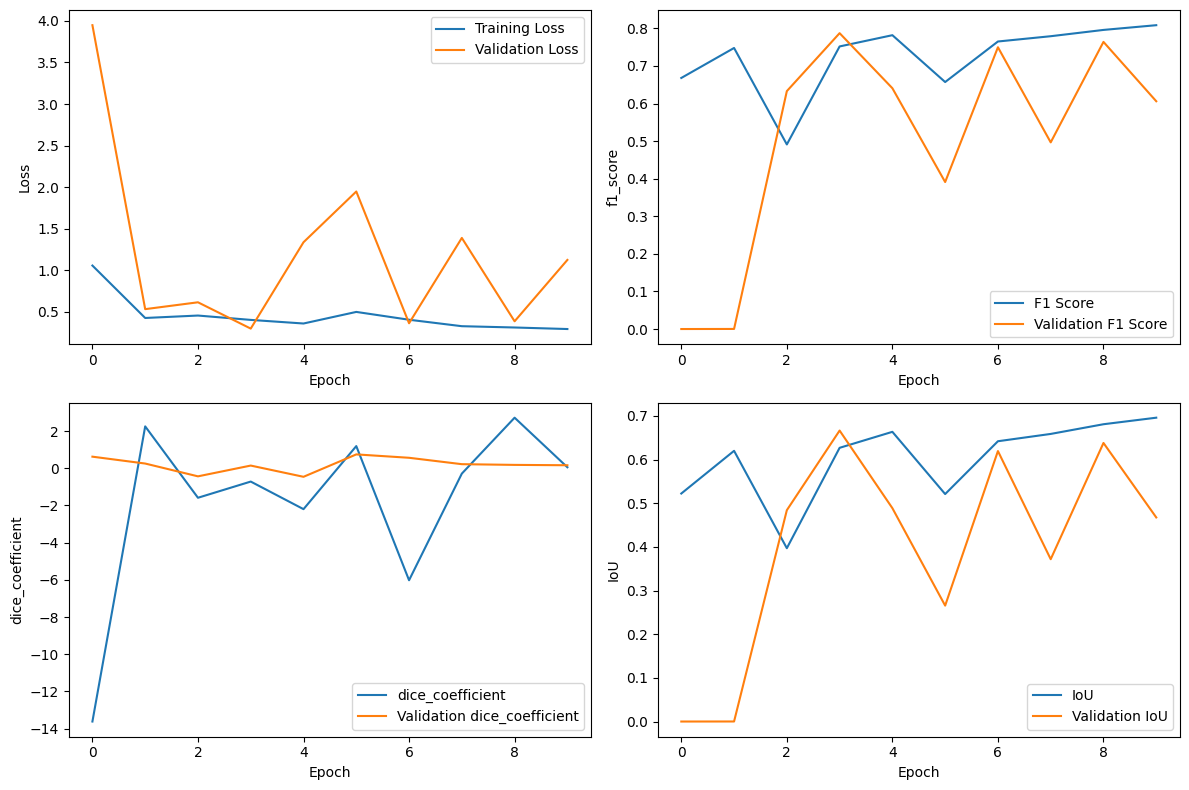

In [13]:
import matplotlib.pyplot as plt

# Plot metrics
plt.figure(figsize=(12, 8))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# F1 Score
plt.subplot(2, 2, 2)
plt.plot(history.history['f1_score'], label='F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('f1_score')
plt.legend()

# dice_coefficient
plt.subplot(2, 2, 3)
plt.plot(history.history['dice_coefficient'], label='dice_coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation dice_coefficient')
plt.xlabel('Epoch')
plt.ylabel('dice_coefficient')
plt.legend()

# IoU
plt.subplot(2, 2, 4)
plt.plot(history.history['iou_score'], label='IoU')
plt.plot(history.history['val_iou_score'], label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
model.save("/content/drive/MyDrive/skin_data/DeeplabV3Plus.h5")